## 5. Dask dataframes

Just like for numpy arrays, Dask implements dataframe wiht an [API](https://docs.dask.org/en/latest/dataframe-api.html) that is very close to the one of Pandas dataframes. In this notebook, we are very briefly reviewing what Pandas dataframes are, and then see their similarities and differences with dask-dataframes.

## 5.1 Pandas dataframes

Let's briefly remember what a dataframe is by loading some tabular data using regular Pandas. We use here a [dataset](https://github.com/guiwitz/Rdatasets/blob/master/csv/mosaicData/Birthdays.csv) of all births in the US from 1969 to 1988 by state.

In [1]:
import pandas as pd

### Import

In [2]:
births = pd.read_csv('../Data/Birthdays.csv')

In [3]:
births

,Unnamed: 0,state,year,month,day,date,wday,births
0,1,AK,1969,1,1,1969-01-01,Wed,14
1,2,AL,1969,1,1,1969-01-01,Wed,174
2,3,AR,1969,1,1,1969-01-01,Wed,78
3,4,AZ,1969,1,1,1969-01-01,Wed,84
4,5,CA,1969,1,1,1969-01-01,Wed,824
...,...,...,...,...,...,...,...,...
372859,372860,VT,1988,12,31,1988-12-31,Sat,21
372860,372861,WA,1988,12,31,1988-12-31,Sat,157
372861,372862,WI,1988,12,31,1988-12-31,Sat,167
372862,372863,WV,1988,12,31,1988-12-31,Sat,45


### Extracting elements

A dataframe is a table where each line represents an observation and that can contain numerical values or categorical values (it can contain lists or other complex objects, but rather shouldn't). Each line has an index that can be used to recover that line:

In [4]:
births.loc[0]

Unnamed: 0             1
state                 AK
year                1969
month                  1
day                    1
date          1969-01-01
wday                 Wed
births                14
Name: 0, dtype: object

One can recover each variable either for a specific index:

In [5]:
births.loc[0].state

'AK'

or for the entire dataframe:

In [6]:
births.state

0         AK
1         AL
2         AR
3         AZ
4         CA
          ..
372859    VT
372860    WA
372861    WI
372862    WV
372863    WY
Name: state, Length: 372864, dtype: object

### Logical indexing

Dataframes also support numpy-like indexing:

In [7]:
births.state == 'AK'

0          True
1         False
2         False
3         False
4         False
          ...  
372859    False
372860    False
372861    False
372862    False
372863    False
Name: state, Length: 372864, dtype: bool

In [8]:
births[births.state == 'AK']

,Unnamed: 0,state,year,month,day,date,wday,births
0,1,AK,1969,1,1,1969-01-01,Wed,14
51,52,AK,1969,1,2,1969-01-02,Thurs,20
102,103,AK,1969,1,3,1969-01-03,Fri,20
153,154,AK,1969,1,4,1969-01-04,Sat,16
204,205,AK,1969,1,5,1969-01-05,Sun,18
...,...,...,...,...,...,...,...,...
372609,372610,AK,1988,12,27,1988-12-27,Tues,38
372660,372661,AK,1988,12,28,1988-12-28,Wed,40
372711,372712,AK,1988,12,29,1988-12-29,Thurs,31
372762,372763,AK,1988,12,30,1988-12-30,Fri,28


### Statistics

The primary goal of dataframes is to perform statistical analysis. Many functions are implemented by default, like the mean, but one can also apply virtually any function to a dataframe using methods like ```apply```.

In [9]:
births.mean()

Unnamed: 0    186432.500000
year            1978.495350
month              6.522394
day               15.741927
births           189.040878
dtype: float64

In [10]:
def myfun(x):
    return x**2

births.births.apply(myfun)

0            196
1          30276
2           6084
3           7056
4         678976
           ...  
372859       441
372860     24649
372861     27889
372862      2025
372863       324
Name: births, Length: 372864, dtype: int64

### Re-arranging

Finally, dataframes can be "re-arranged" in many ways to select and group particulars sub-categories. The most commonly function is ```groupy``` which allows to create a set of groups based on the elements of a column, like here grouping data by states:

In [11]:
births.groupby('state').mean()

,Unnamed: 0,year,month,day,births
state,,,,,
AK,186490.363674,1978.499726,6.523542,15.731727,25.374350
AL,186357.881565,1978.492615,6.522566,15.743846,165.039934
AR,186453.473461,1978.497674,6.522845,15.739808,93.600547
AZ,186436.387141,1978.496854,6.521067,15.739672,129.580575
CA,186215.389352,1978.484778,6.522048,15.770375,1067.956997
CO,186518.550034,1978.501027,6.522930,15.729637,129.552088
CT,186394.528583,1978.494530,6.519967,15.743572,112.737691
DC,186399.759130,1978.494597,6.521953,15.741622,58.195732
DE,186472.827699,1978.498426,6.522650,15.733817,25.825236


Pandas is a huge library that offers all necessary tools for advanced data science and is used in many other packages such as the plotting library seaborn or the machine learning packages scikit-learn (you can learn a bit more about Pandas e.g. [here](https://github.com/guiwitz/Pandas_course)).

## 5.2 Dask dataframes

We are now going to see the equivalent operations for dask dataframes. First of all, we start dask by creating a client-cluster pair:

In [12]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:60867 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


### Import

We import now the same csv file, but now as a dask-dataframe and not a pandas-dataframe:

In [13]:
from dask import dataframe as dd

In [14]:
births_da = dd.read_csv('../Data/Birthdays.csv')

At import time, Dask checks the first rows to determine the type of each column. Of course this can lead to trouble if the contents of a column is not consistent (you will see an example of this in the exercises), and like in Pandas, one can enforce types at import time. 

In [15]:
births_da

,Unnamed: 0,state,year,month,day,date,wday,births
npartitions=1,,,,,,,,
,int64,object,int64,int64,int64,object,object,int64
,...,...,...,...,...,...,...,...


We see that the dataframe itself is still empty. It's only going to be filled at ```compute()``` time. The only information that we have is the length of the table which is pre-computed:

In [16]:
len(births_da)

372864

If we want to have a clearer idea of the contents we can used the ```head()``` function:

In [17]:
births_da.head()

,Unnamed: 0,state,year,month,day,date,wday,births
0,1,AK,1969,1,1,1969-01-01,Wed,14
1,2,AL,1969,1,1,1969-01-01,Wed,174
2,3,AR,1969,1,1,1969-01-01,Wed,78
3,4,AZ,1969,1,1,1969-01-01,Wed,84
4,5,CA,1969,1,1,1969-01-01,Wed,824


This dataset is very small and therefore it is not split into multiple parts as we expect dask to do (like chunks for arrays):

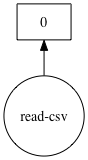

In [18]:
births_da.visualize()

For the purpose of illustration, we are going to enforce such a splitting here at import time. Enforcing such a split, can also be practical if one has a table with known series of blocks on which computations have to be done together, in order to avoid communication between tasks.

In [19]:
births_da = dd.read_csv('../Data/Birthdays.csv', blocksize=5e6)

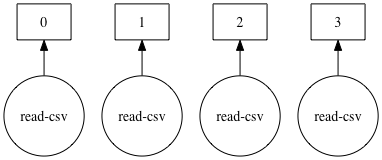

In [20]:
births_da.visualize()

We see now that the data import is split into five chunks. Let's now try out the different dataframe operations we have seen for Pandas above.

### Extracting elements

Dask-dataframes use the same operations to extract specific locations or series. However one has to be very careful if the data is split into chunks. For example let's see what happens with ```loc[]```:

In [21]:
births_da.loc[0]

,Unnamed: 0,state,year,month,day,date,wday,births
npartitions=4,,,,,,,,
,int64,object,int64,int64,int64,object,object,int64
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


As before for arrays or for delayed, the function is not executed directly. We need to use ```compute``` whenever we want the actual result:

In [22]:
births_da.loc[0].compute()

,Unnamed: 0,state,year,month,day,date,wday,births
0,1,AK,1969,1,1,1969-01-01,Wed,14
0,113681,HI,1975,2,3,1975-02-03,Mon,50
0,224785,MO,1981,1,19,1981-01-19,Mon,223
0,335813,MS,1987,1,5,1987-01-05,Mon,127


Remember what the output was for the classical dataframe:

In [23]:
births.loc[0]

Unnamed: 0             1
state                 AK
year                1969
month                  1
day                    1
date          1969-01-01
wday                 Wed
births                14
Name: 0, dtype: object

What happened here? As our dataframe is imported as chunks, each chunk re-starts indexing at 0. Since we had four chunks, we have four locations 0. So be careful with automatic indexing. To fix that, we can use one of the column as index, if something suitable is present. Here we can use the first column ```Unnamed: 0``` for that:

In [24]:
births_da = births_da.set_index('Unnamed: 0')

In [25]:
births_da.loc[1].compute()

,state,year,month,day,date,wday,births
Unnamed: 0,,,,,,,
1,AK,1969,1,1,1969-01-01,Wed,14


### Logical indexing

Logical indexing works exactly like for arrays. Since this does not use the dataframe index, there is no "chunk-problem":

In [26]:
subtable = births_da[births_da.state == 'AK']

In [27]:
subtable

,state,year,month,day,date,wday,births
npartitions=4,,,,,,,
1,object,int64,int64,int64,object,object,int64
113681,...,...,...,...,...,...,...
224785,...,...,...,...,...,...,...
335813,...,...,...,...,...,...,...
372864,...,...,...,...,...,...,...


and see that there are still no data there. Let's look at the task graph:

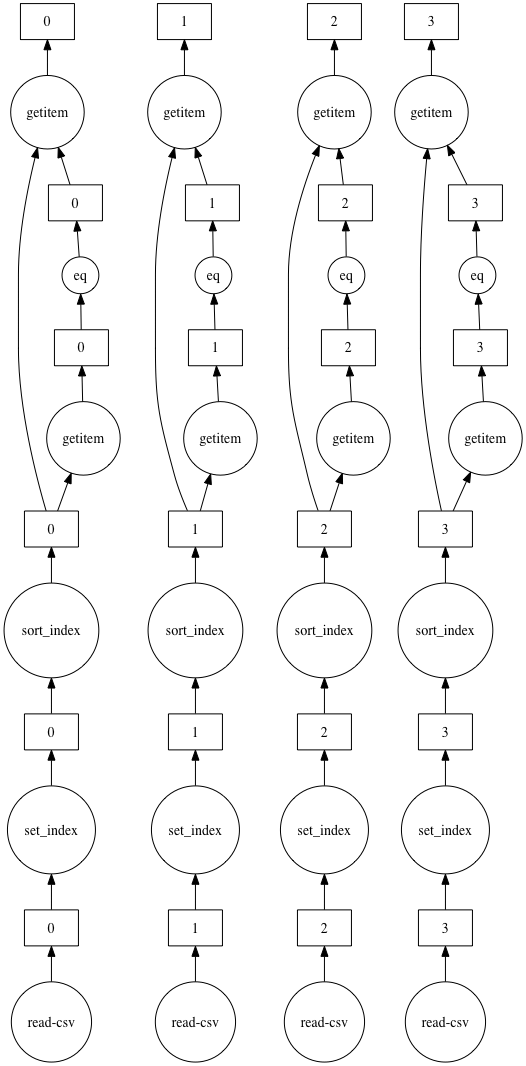

In [28]:
subtable.visualize()

In [29]:
subtable.compute()

,state,year,month,day,date,wday,births
Unnamed: 0,,,,,,,
1,AK,1969,1,1,1969-01-01,Wed,14
52,AK,1969,1,2,1969-01-02,Thurs,20
103,AK,1969,1,3,1969-01-03,Fri,20
154,AK,1969,1,4,1969-01-04,Sat,16
205,AK,1969,1,5,1969-01-05,Sun,18
...,...,...,...,...,...,...,...
372610,AK,1988,12,27,1988-12-27,Tues,38
372661,AK,1988,12,28,1988-12-28,Wed,40
372712,AK,1988,12,29,1988-12-29,Thurs,31


### Statistics

Extracting statistics also work seamlessly like for Pandas dataframes, but here again an optimized task graph is calculated by Dask. For example here when calculating the variance and mean of a dataframe:

In [30]:
mean_values = births_da.mean()
var_values = births_da.var()

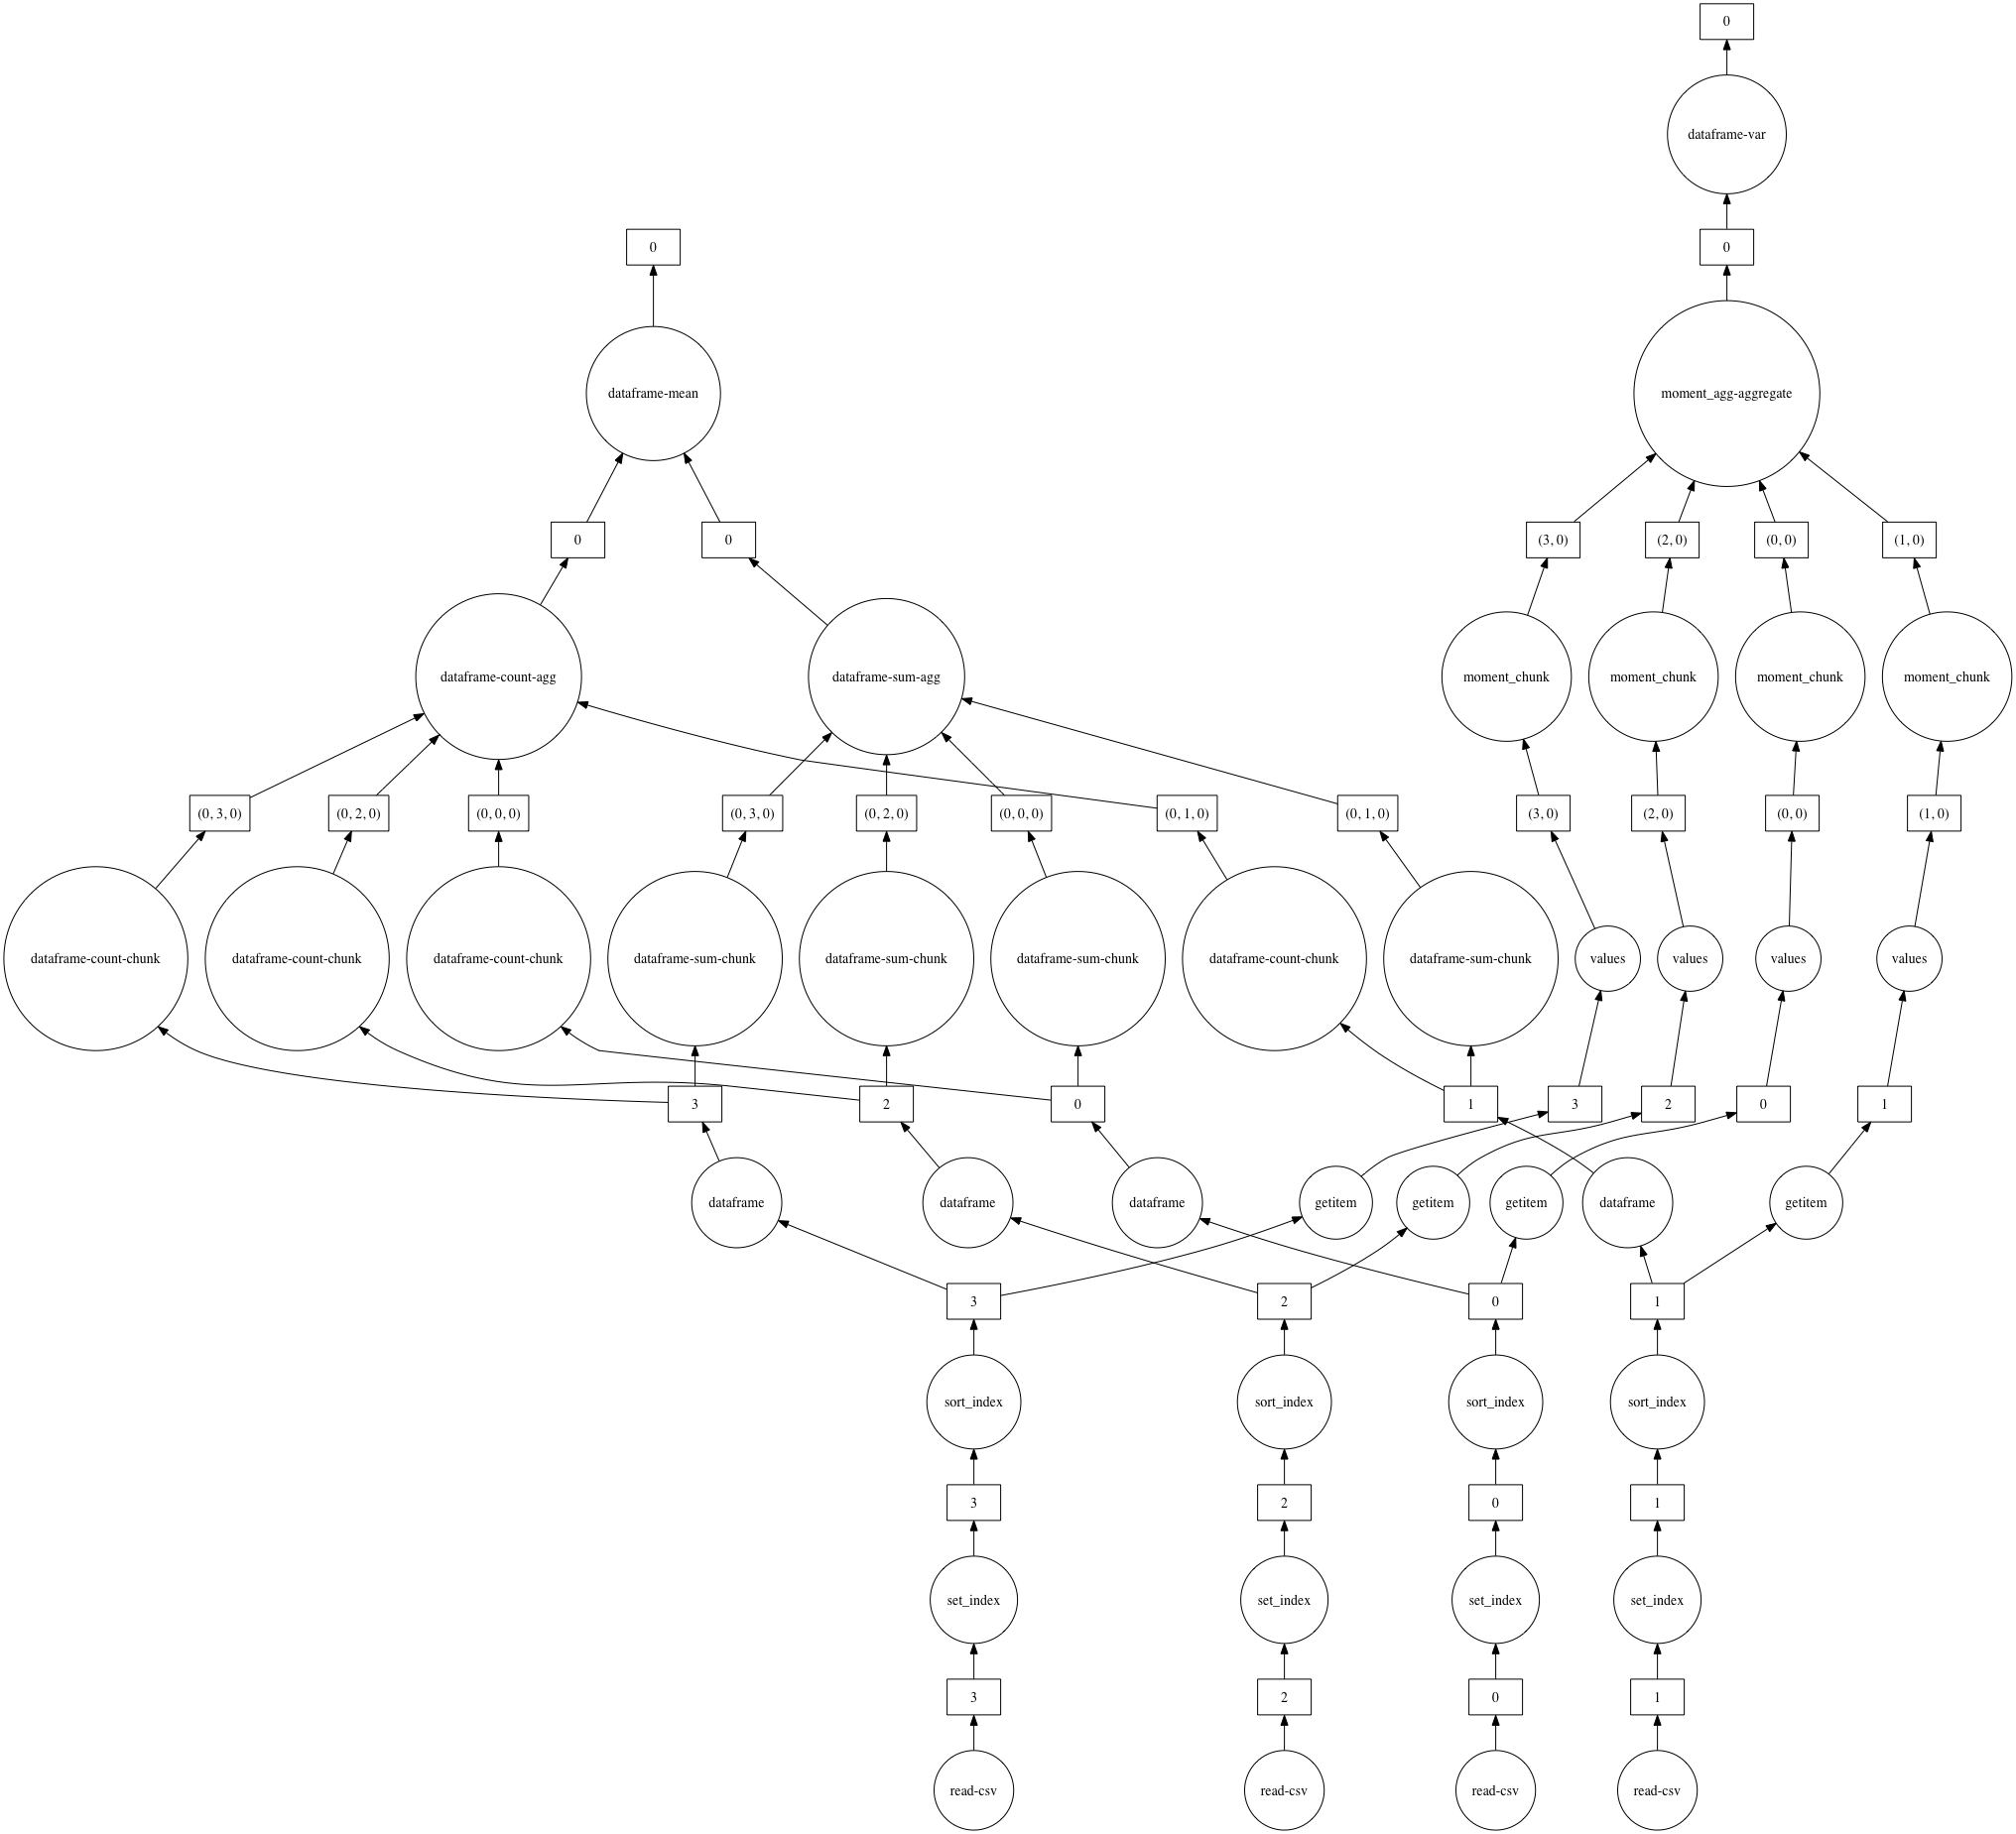

In [31]:
import dask
dask.visualize((mean_values, var_values))

The ```apply``` function also works and is of course parallelized as well here:

/Users/gw18g940/miniconda3/envs/dask_course/lib/python3.8/site-packages/dask/dataframe/core.py:4315: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


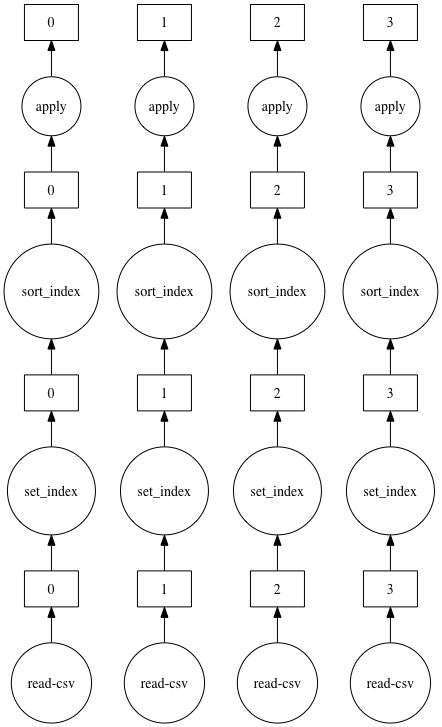

In [33]:
births_da.apply(lambda x: x['births']**2, axis=1).visualize()

### Re-arranging

The important ```group``` function is also available in Dask:

In [34]:
births_grouped = births_da.groupby('state')

In [35]:
births_group_mean = births_grouped.mean()

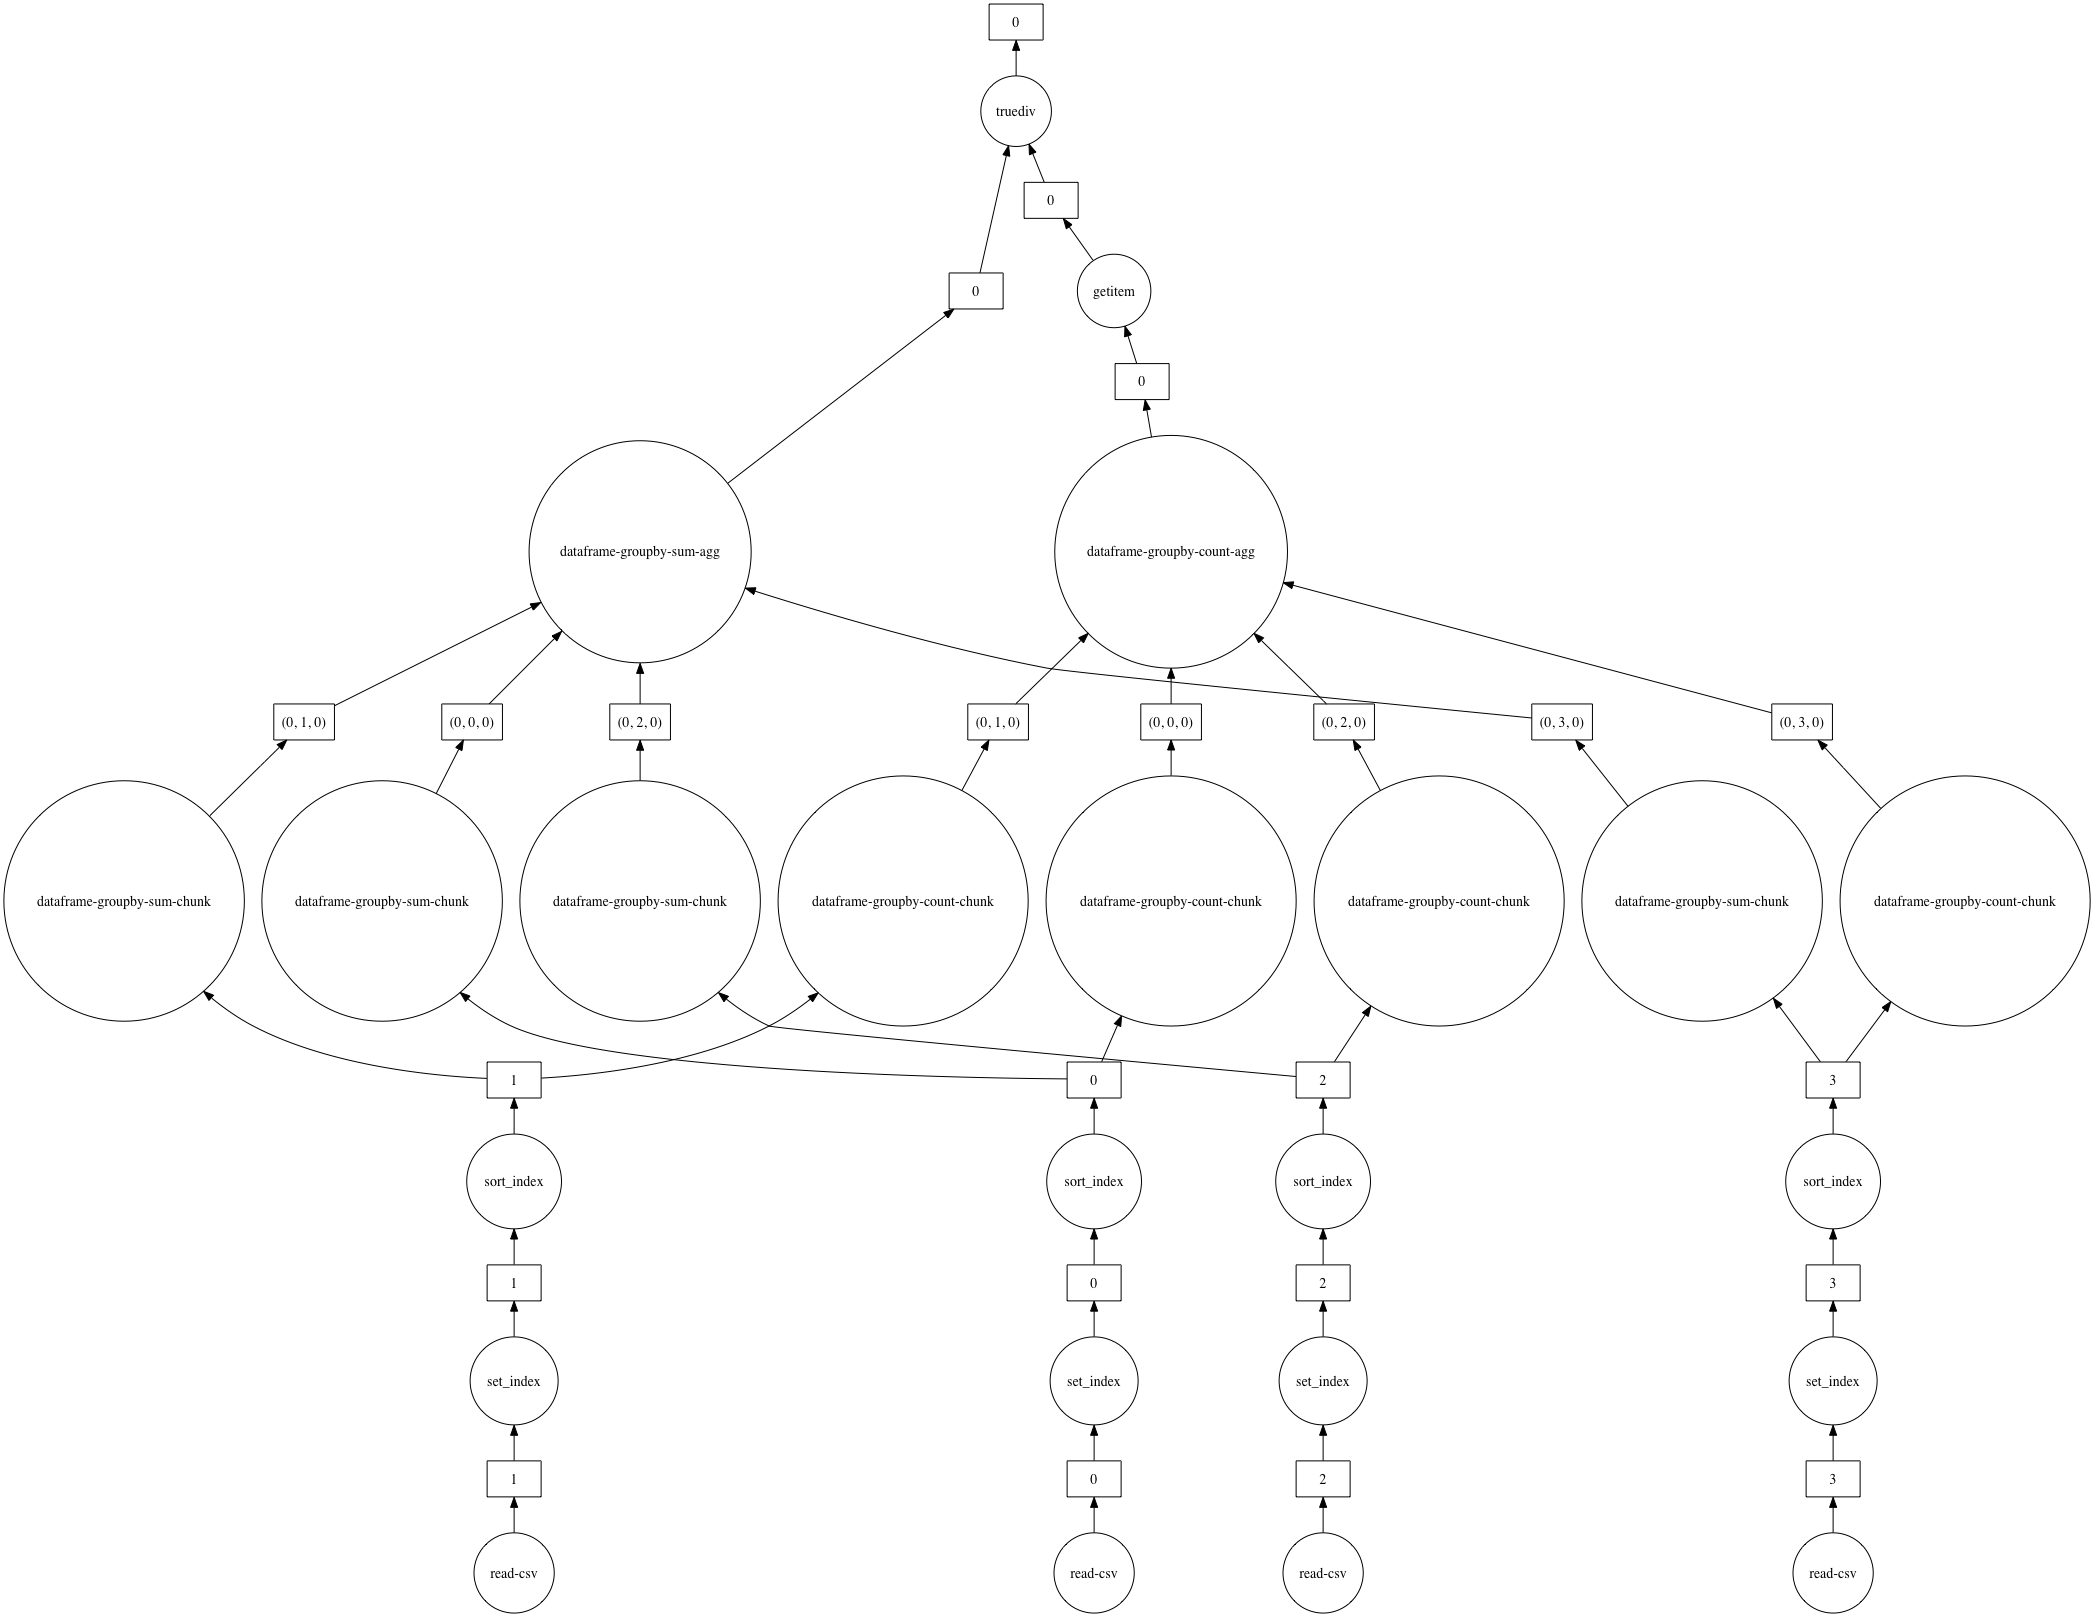

In [36]:
births_group_mean.visualize()

In [37]:
mean_births = births_group_mean.compute()
mean_births

,year,month,day,births
state,,,,
AK,1978.499726,6.523542,15.731727,25.374350
AL,1978.492615,6.522566,15.743846,165.039934
AR,1978.497674,6.522845,15.739808,93.600547
AZ,1978.496854,6.521067,15.739672,129.580575
CA,1978.484778,6.522048,15.770375,1067.956997
CO,1978.501027,6.522930,15.729637,129.552088
CT,1978.494530,6.519967,15.743572,112.737691
DC,1978.494597,6.521953,15.741622,58.195732
DE,1978.498426,6.522650,15.733817,25.825236


In [38]:
mean_births.births.nlargest(10)

state
CA    1067.956997
TX     718.072715
NY     702.754534
IL     488.039923
OH     455.844514
PA     444.353615
MI     387.427694
FL     359.148898
NJ     271.122797
GA     251.521739
Name: births, dtype: float64

## Larger files

The birth dataset is not very large and dask doesn't really help because it fits in RAM and the overhead of communication betweeen processes is too important.

Let's look at a case where files are larger and/or our dataset is split between multiple files. This dataset is taken from [Zenodo](https://zenodo.org/record/834557#.Xj0fMxP0nOS) and represents an analysis of all edits made to Wikipedia pages from its beginning to 2016.

Data are split among multiple zip files, each containing multiple "largish" (500Mb) CSV files. Let's look at one of them:

In [39]:
filepath = '../Data/20161101-current_content-parts-1-50-pageids-12-117215/20161101-current_content-part1-12-1728.csv'


In [40]:
wikipedia_changes = dd.read_csv(filepath)

In [41]:
wikipedia_changes

,page_id,last_rev_id,token_id,str,origin_rev_id,in,out
npartitions=9,,,,,,,
,int64,int64,int64,object,int64,object,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


We see that here Dask decided by default to split the file into 9 partitions because of its size. Let's look at a few lines:

In [42]:
wikipedia_changes.head()

,page_id,last_rev_id,token_id,str,origin_rev_id,in,out
0,12,746687538,1623,see,233194,"[391426, 988138, 6540619, 6551217, 12116305, 1...","[391368, 407005, 6539886, 6540818, 12116304, 1..."
1,12,746687538,1624,also,233194,"[391426, 988138, 6540619, 6551217, 12116305, 1...","[391368, 407005, 6539886, 6540818, 12116304, 1..."
2,12,746687538,3519,.,178538,"[391426, 18309960, 18310083, 47354530, 1328933...","[391381, 871060, 18310026, 18310134, 47417405,..."
3,12,746687538,4507,=,320749,"[83542729, 160471915]","[367665, 83543709]"
4,12,746687538,4508,=,320749,"[83542729, 160471915]","[367665, 83543709]"


The ```page_id``` corresponds to a specific Wikipedia topic, the ```str``` represents a given word that has been added or modified. The ```in``` and ```out``` arrays represent a sequence of events (referenced by an ID) of adding and removal, i.e. the longer the list, the most often this word has been edited.

Here we can verify that with the default import into chunks, we have again the indexing problem:

In [43]:
wikipedia_changes.loc[0].compute()

,page_id,last_rev_id,token_id,str,origin_rev_id,in,out
0,12,746687538,1623,see,233194,"[391426, 988138, 6540619, 6551217, 12116305, 1...","[391368, 407005, 6539886, 6540818, 12116304, 1..."
0,593,744804419,36875,by,155262821,"[164630979, 167839234, 183617334, 185043789, 1...","[164630961, 167839008, 183617090, 185043774, 1..."
0,700,746750216,1260,check,619139,"[61773188, 91845565]","[61773072, 91844748]"
0,783,746647937,207927,[,655587695,[707531216],[707530825]
0,864,745162899,76425,|,262349476,"[314394579, 347669693, 348610355, 350408772, 4...","[314394537, 347669682, 348610301, 350408703, 4..."
0,991,744928000,3073,important,18972725,"[77455083, 87982073, 156235181, 156235404, 163...","[77453607, 87981675, 156235168, 156235397, 163..."
0,1175,746229520,33743,]],576608421,[654529644],[654529496]
0,1347,746716698,26536,jpg,163084252,[294293698],[294293671]
0,1537,747000036,174476,</,477994012,"[489689538, 496207384, 511974564, 602763537, 6...","[489689469, 496207260, 497925062, 579792032, 6..."


However we can use indexing without trouble. Let's recover the 20 first modifications of the page with ```page_id``` 593

In [44]:
first_words = wikipedia_changes[wikipedia_changes.page_id==593].loc[0:20].compute()

Let's see what strings we have here:

In [45]:
' '.join(list(first_words.str.values))

'by [[ george ]] , are puppet - animated films which typically use a different version of a puppet for different'

Seems to be [this page](https://www.google.com/search?q=animated+films+which+typically+use+a+different+version+of+a+puppet+for+different&oq=animated+films+which+typically+use+a+different+version+of+a+puppet+for+different&aqs=chrome..69i57.167j0j4&sourceid=chrome&ie=UTF-8).

## Compare Pandas and Dask

Let's see how Pandas and Dask compare on this single "largish" (500Mb) file. We can for example count occurrences of single words. We can use the same functions as in Pandas (```value_counts```) as dasks implements a very close API:

In [45]:
count_str = wikipedia_changes.str.value_counts()

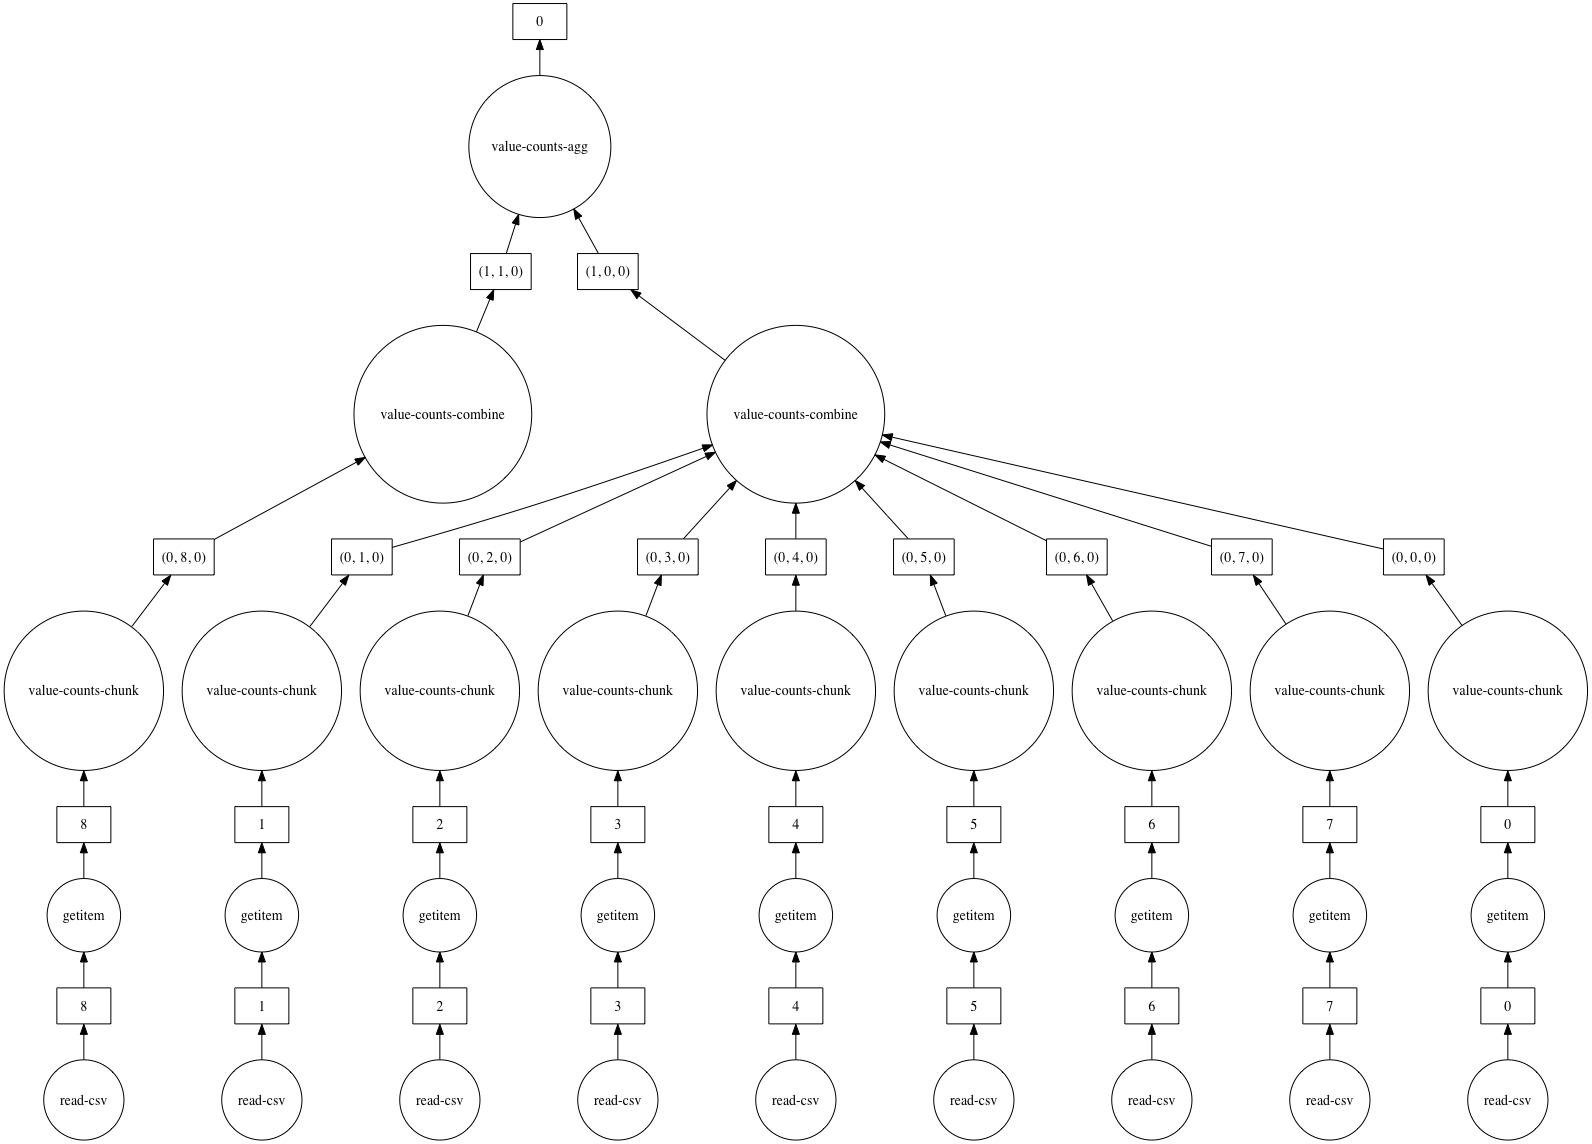

In [46]:
count_str.visualize()

In [47]:
real_count = count_str.compute()

Let's look at the the few most used words or "tokens":

In [48]:
real_count.head(n = 30)

|        256476
=        229648
.        210243
,        181501
the      157474
[[       141926
]]       141926
/        106560
of       105209
-         90254
and       74325
in        59890
>         57475
ref       54172
:         52983
)         47957
(         47930
to        44798
a         44271
}}        41837
{{        41745
*         39386
<         38841
</        28086
;         27291
&         25329
is        21762
as        18853
for       17466
title     16764
Name: str, dtype: int64

Now we compare the performances of Pandas and Dask:

In [49]:
%%time
wikipedia_changes = dd.read_csv(filepath)
count_str = wikipedia_changes.str.value_counts()
real_count = count_str.compute()

CPU times: user 193 ms, sys: 36.2 ms, total: 229 ms
Wall time: 4.21 s


In [50]:
%%time
wiki_pd = pd.read_csv(filepath)
count_str = wiki_pd.str.value_counts()

CPU times: user 4.9 s, sys: 502 ms, total: 5.4 s
Wall time: 5.43 s


As before with arrays, we don't see any difference with such a reasonable size dataset. **Big data tools often perform worse than classical tools.**

## Multiple large files

We only looked at a tiny part of the dataset and found no big gain with Dask. We will now look at much more of the dataset (but still not the complete one).

Dask offers the very useful feature of being able to open multiple files as one dask-dataframe by using the wild-card ```*``` or generating a file list. For example here, we have multiple CSV files in the folder and we can just say:

In [51]:
wiki_large = dd.read_csv('../Data/20161101-current_content-parts-1-50-pageids-12-117215/2016*.csv')

In [52]:
wiki_large

,page_id,last_rev_id,token_id,str,origin_rev_id,in,out
npartitions=35,,,,,,,
,int64,int64,int64,object,int64,object,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


We see many more partitions, meaning that dask indeed considered all files. If we wanted to import the files with pandas we would have more trouble:

In [53]:
import glob
all_files = glob.glob('../Data/20161101-current_content-parts-1-50-pageids-12-117215/2016*.csv')
#wiki_large_pd = pd.concat((pd.read_csv(f) for f in all_files))

In [54]:
all_files

['../Data/20161101-current_content-parts-1-50-pageids-12-117215/20161101-current_content-part2-1729-3376.csv',
 '../Data/20161101-current_content-parts-1-50-pageids-12-117215/20161101-current_content-part3-3378-4631.csv',
 '../Data/20161101-current_content-parts-1-50-pageids-12-117215/20161101-current_content-part1-12-1728.csv',
 '../Data/20161101-current_content-parts-1-50-pageids-12-117215/20161101-current_content-part4-4633-5902.csv']

Let's time again the same taks as before:

In [55]:
%%time
wiki_large = dd.read_csv('../Data/20161101-current_content-parts-1-50-pageids-12-117215/2016*.csv')
count_str = wiki_large.str.value_counts()
real_count = count_str.compute()

CPU times: user 668 ms, sys: 127 ms, total: 795 ms
Wall time: 14.7 s


In [56]:
%%time
all_files = glob.glob('../Data/20161101-current_content-parts-1-50-pageids-12-117215/2016*.csv')
wiki_large_pd = pd.concat([pd.read_csv(f) for f in all_files])
count_str = wiki_large_pd.str.value_counts()

CPU times: user 22.6 s, sys: 3.17 s, total: 25.8 s
Wall time: 26 s


## Exercise

1. Create a dask-dataframe from one of the files in the ```../Data/NYC_Taxi``` folder (see [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) for information)
2. Using default import, in how many chunks is the data split ? 
3. Try to understand the file by looking at the columns and the few first lines
4. Calculate the average trip distance for each pick-up location (PULocationID) using groupy and get the 10 longest trips. When executing, you should get an error. Use the information provided in the error report to fix the issue.
5. Which PULocationID has the largest distances. Check in the ```taxi+_zone_lookup.csv``` file if it makes sense.
6. Load all the trip files (for several months) using Dask
7. Change the type of the drop-off time to ```'M8[us]```, the numpy dtype for timestamp dates
8. Using ```apply``` extract the month from that time-stamp
9. Group data by month, and calculate the sum of trip distances
10. Plot the total distance by month